<div style="border-radius:10px;
            border:#0b0265 solid;
           background-color:#b3ffff;
           font-size:110%;
           letter-spacing:0.5px;
            text-align: center">

<center><h1 style="padding: 25px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Emojify ❤️ 👍 ⚾</h1></center>

</div>

We're going to use word vector representations to build an Emojifier. 
🤩 💫 🔥

>"Congratulations on the promotion! Let's get coffee and talk. Love you!"   

The emojifier can automatically turn this into:
>"Congratulations on the promotion! 👍  Let's get coffee and talk. ☕️ Love you! ❤️"

We'll implement a model which inputs a sentence (such as "Let's go see the baseball game tonight!") and finds the most appropriate emoji to be used with this sentence (⚾️).

Using Word Vectors to Improve Emoji Lookups:

* We can make a more flexible emoji interface by using word vectors.
* When using word vectors, you'll see that even if your training set explicitly relates only a few words to a particular emoji, your algorithm will be able to generalize and associate additional words in the test set to the same emoji.
    * This works even if those additional words don't even appear in the training set. 
    * This allows us to build an accurate classifier mapping from sentences to emojis, even using a small training set. 

What we'll build:

1. In this exercise, we'll start with a baseline model (Emojifier-V1) using word embeddings.
2. Then we will build a more sophisticated model (Emojifier-V2) that further incorporates an LSTM.

In [1]:
!pip install emoji
import numpy as np
import emoji
import matplotlib.pyplot as plt
import pandas as pd

Dataset EMOJISET:

Let's start by building a simple baseline classifier. 

We have a tiny dataset (X, Y) where:
- X contains 127 sentences (strings).
- Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence.

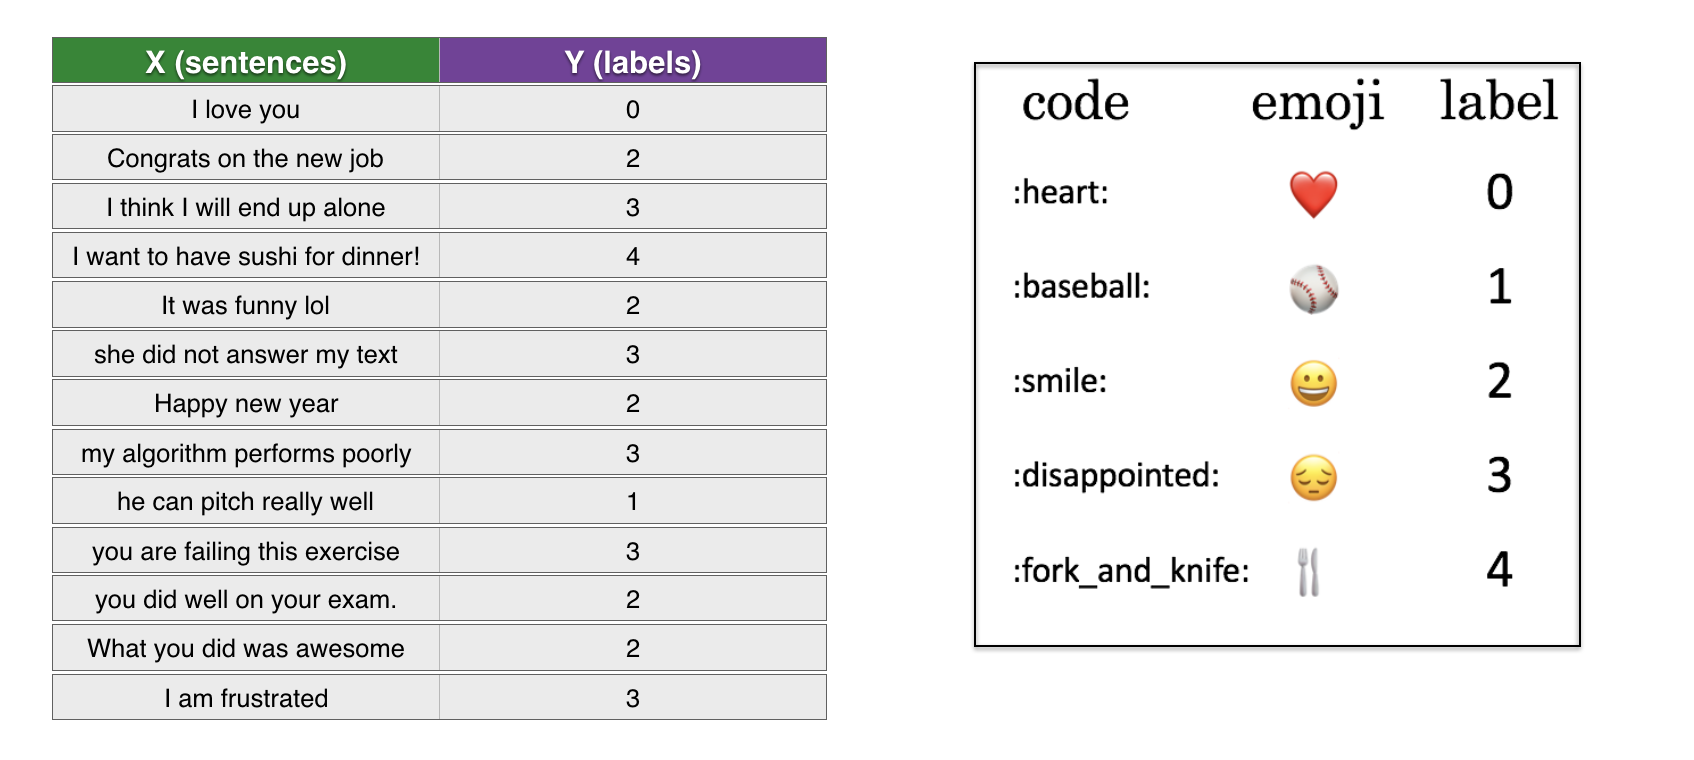

We load the dataset using the code below. The dataset is split between training (127 examples) and testing (56 examples).

In [11]:
Train = pd.read_csv('train_emoji.csv')
X_train = np.asarray(Train.iloc[:,0])
Y_train = np.asarray(Train.iloc[:,1])
Test = pd.read_csv('test_emoji.csv')
X_test = np.asarray(Test.iloc[:,0])
Y_test = np.asarray(Test.iloc[:,1])

In [12]:
maxLen = len(max(X_train, key=len).split())

We run the following cell to print sentences from X_train and corresponding labels from Y_train. 
* Change `idx` to see different examples. 

In [13]:
emoji_dictionary = {"0": "\u2764\uFE0F",
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)

In [14]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾
she did not answer my text  😞


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The parameter 'use_aliases' in emoji.emojize() is deprecated and will be removed in version 2.0.0. Use language='alias' instead.
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  # This is added back by InteractiveShellApp.init_path()


## **Emojifier-V1:**

In this section, we'll implement a baseline model called "Emojifier-v1".

Inputs and Outputs:
* The input of the model is a string corresponding to a sentence (e.g. "I love you"). 
* The output will be a probability vector of shape (1,5), (indicating that there are 5 emojis to choose from).
* The (1,5) probability vector is passed to an argmax layer, which extracts the index of the emoji with the highest probability.

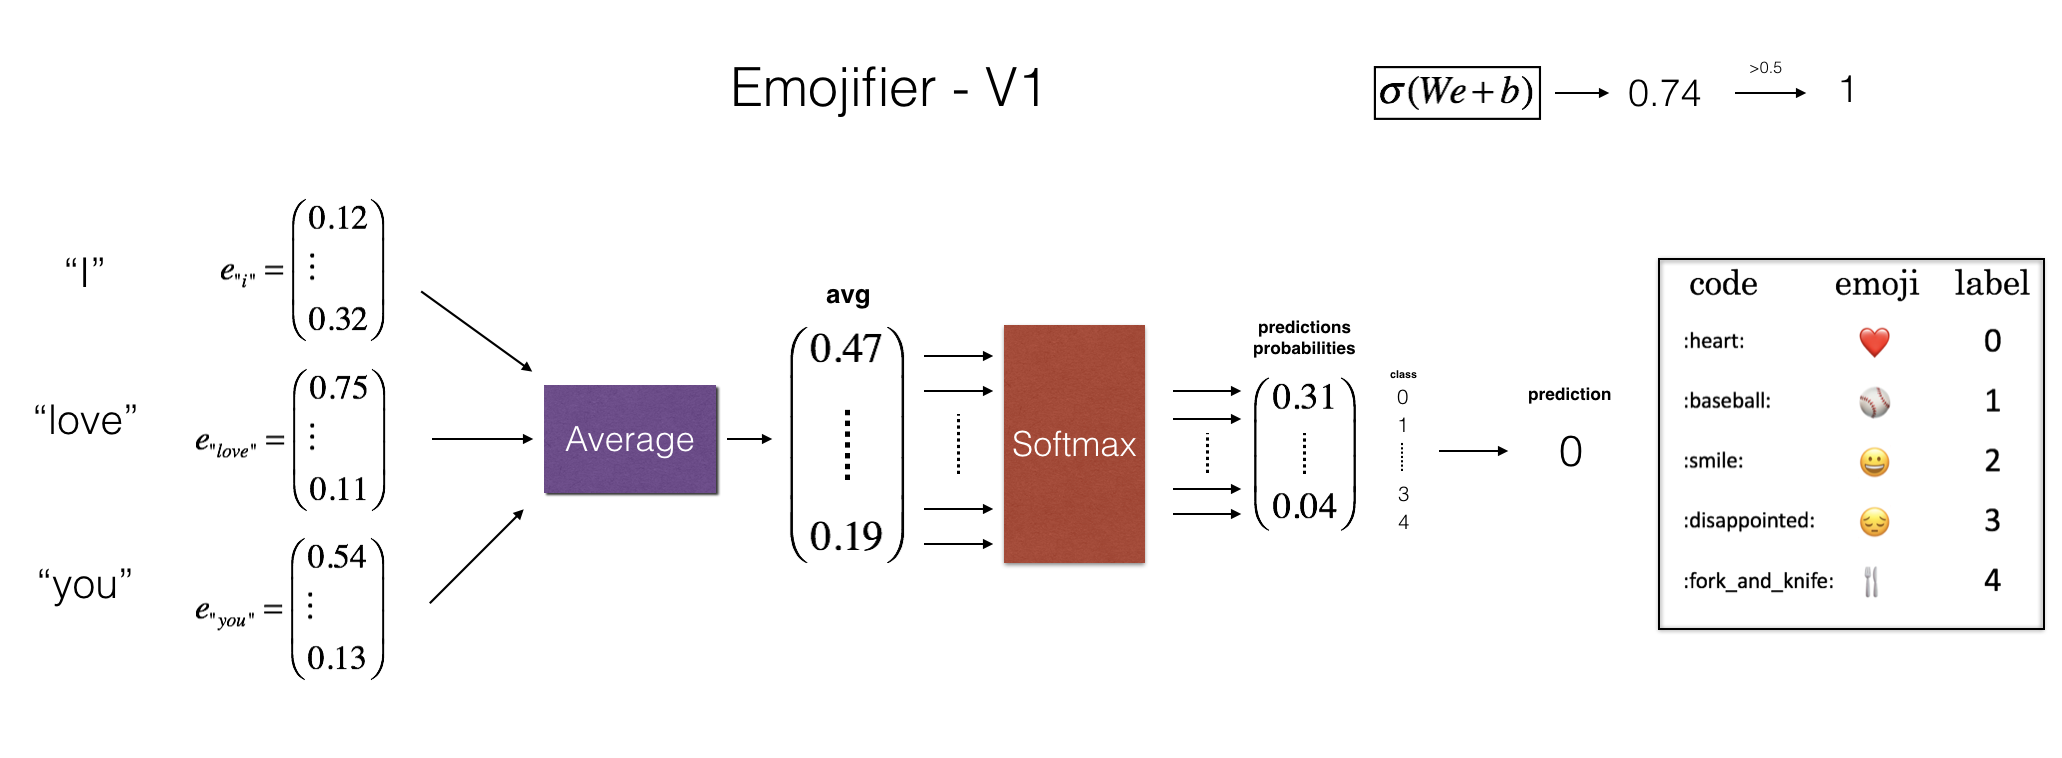

One-hot Encoding:

* To get our labels into a format suitable for training a softmax classifier, convert $Y$ from its current shape  $(m, 1)$ into a "one-hot representation" $(m, 5)$, 
    * Each row is a one-hot vector giving the label of one example.
    * Here, `Y_oh` stands for "Y-one-hot" in the variable names `Y_oh_train` and `Y_oh_test`: 

In [15]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [16]:
idx = 50
print(f"Sentence '{X_train[idx]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I think I will end up alone' has label index 3, which is emoji 😞
Label index 3 in one-hot encoding format is [0. 0. 0. 1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The parameter 'use_aliases' in emoji.emojize() is deprecated and will be removed in version 2.0.0. Use language='alias' instead.
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  # This is added back by InteractiveShellApp.init_path()


All the data is now ready to be fed into the Emojify-V1 model. We're ready to implement the model.

**Implementing Emojifier-V1:**

The first step is to:
* Convert each word in the input sentence into their word vector representations.
* Take an average of the word vectors. 

We'll use pre-trained 50-dimensional GloVe embeddings. 

We run the following cell to load the `word_to_vec_map`, which contains all the vector representations.

In [17]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [18]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
directory = 'drive/MyDrive/Datasets/Pretrained Models & weights/glove.6B.50d.txt'

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(directory)

Mounted at /content/drive


In [19]:
word = 'cucumber'
idx = 289846
print('the index of', word, 'in the vocabulary is', word_to_index[word])
print('the', str(idx) + 'th word in the vocabulary is', index_to_word[idx])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


sentence to avg:

We implement `sentence_to_avg()` 

We'll need to carry out two steps:

1. Convert every sentence to lower-case, then split the sentence into a list of words. 
    * `X.lower()` and `X.split()` might be useful. 😉
2. For each word in the sentence, access its GloVe representation.
    * Then take the average of all of these word vectors.

In [20]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (J,), where J can be any number
    """
    #Get a valid word contained in the word_to_vec_map. 
    any_word = list(word_to_vec_map.keys())[0]
    
    #Step 1: Split sentence into list of lower case words
    words = sentence.lower().split()

    #Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros(word_to_vec_map[any_word].shape)
    
    #Initialize count to 0
    count = 0
    
    #Step 2: average the word vectors. You can loop over the words in the list "words".
    for w in words:
        #Check that word exists in word_to_vec_map
        if w in list(word_to_vec_map.keys()):
            avg += word_to_vec_map[w]
            #Increment count
            count +=1
          
    if count > 0:
        #Get the average. But only if count > 0
        avg = avg/count
        
    return avg

**Implement the Model:**

After using `sentence_to_avg()` we need to:
* Pass the average through forward propagation
* Compute the cost
* Backpropagate to update the softmax parameters

We implement the `model()` function. 

* The equations we need to implement in the forward pass and to compute the cross-entropy cost are below:
* The variable $Y_{oh}$ ("Y one hot") is the one-hot encoding of the output labels. 

$$ z^{(i)} = Wavg^{(i)} + b$$

$$ a^{(i)} = softmax(z^{(i)})$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)$$

In [21]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def predict(X, Y, W, b, word_to_vec_map):
    """
    Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of your model over the given set.
    
    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the label emoji, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros((m, 1))
    any_word = list(word_to_vec_map.keys())[0]
    #Number of classes  
    n_h = word_to_vec_map[any_word].shape[0] 
    
    for j in range(m):                       #Loop over training examples
        
        #Split jth test example (sentence) into list of lower case words
        words = X[j].lower().split()
        
        #Average words' vectors
        avg = np.zeros((n_h,))
        count = 0
        for w in words:
            if w in word_to_vec_map:
                avg += word_to_vec_map[w]
                count += 1
        
        if count > 0:
            avg = avg / count

        #Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
        
    print('Accuracy: '  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))
    
    return pred    

In [22]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    #Get a valid word contained in the word_to_vec_map 
    any_word = list(word_to_vec_map.keys())[0]
        
    #Initialize cost. It is needed during grading
    cost = 0
    
    #Define number of training examples
    m = Y.shape[0]                             #Number of training examples
    n_y = len(np.unique(Y))                    #Number of classes  
    n_h = word_to_vec_map[any_word].shape[0]   #Dimensions of the GloVe vectors 
    
    #Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    #Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    #Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
            
            #Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            #Forward propagate the avg through the softmax layer
            z = np.add(np.dot(W,avg),b)
            a = softmax(z)

            #Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = -np.sum(np.dot(Y_oh[i], np.log(a)))
            
            #Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            #Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print('Epoch: ' + str(t) + ' --- cost = ' + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

Next cell train the model and learn the softmax parameters (W, b).

In [23]:
np.random.seed(1)
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.9522215788215656
Accuracy: 0.3435114503816794
Epoch: 100 --- cost = 0.08022475629811014
Accuracy: 0.9312977099236641
Epoch: 200 --- cost = 0.04474224750291262
Accuracy: 0.9541984732824428
Epoch: 300 --- cost = 0.03430976280578106
Accuracy: 0.9694656488549618
[[2.]
 [3.]
 [0.]
 [4.]
 [0.]
 [3.]
 [2.]
 [3.]
 [1.]
 [3.]
 [3.]
 [1.]
 [3.]
 [2.]
 [3.]
 [2.]
 [3.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [1.]
 [4.]
 [3.]
 [3.]
 [4.]
 [0.]
 [3.]
 [4.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [3.]
 [4.]
 [2.]
 [2.]
 [0.]
 [2.]
 [3.]
 [0.]
 [3.]
 [2.]
 [4.]
 [3.]
 [0.]
 [3.]
 [3.]
 [3.]
 [4.]
 [2.]
 [1.]
 [1.]
 [1.]
 [2.]
 [3.]
 [1.]
 [0.]
 [0.]
 [0.]
 [3.]
 [4.]
 [4.]
 [2.]
 [2.]
 [1.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [0.]
 [3.]
 [3.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [4.]
 [3.]
 [3.]
 [2.]
 [4.]
 [0.]
 [0.]
 [3.]
 [3.]
 [3.]
 [3.]
 [2.]
 [0.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [3.]
 [2.]
 [2.]
 [2.]
 [4.]
 [1.]
 [1.]
 [3.]
 [3.]
 [4.]
 [1.]
 [2.]
 [1.]
 [1.]
 [3.]
 [1.]
 [0.]

Now let's see how it does on the test set:

In [24]:
print('Training set:')
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9770992366412213
Test set:
Accuracy: 0.8545454545454545


**Note**:
* Random guessing would have had 20% accuracy, given that there are 5 classes. (1/5 = 20%).
* This is pretty good performance after training on only 127 examples. 


The Model Matches Emojis to Relevant Words:

In the training set, the algorithm saw the sentence 
>"I love you." 

with the label ❤️. 
* We can check that the word "cherish" does not appear in the training set. 
* Nonetheless, let's see what happens if you write "I cherish you."

In [18]:
def print_predictions(X, pred):
    print()
    for i in range(X.shape[0]):
        print(X[i], label_to_emoji(int(pred[i])))

In [19]:
X_my_sentences = np.array(['i cherish you', 'i love you', 'funny lol', 'lets play with a ball', 'food is ready', 'not feeling happy'])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i cherish you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The parameter 'use_aliases' in emoji.emojize() is deprecated and will be removed in version 2.0.0. Use language='alias' instead.
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  # This is added back by InteractiveShellApp.init_path()


* Because *adore* has a similar embedding as *love*, the algorithm has generalized correctly even to a word it has never seen before. 
* Words such as *heart*, *dear*, *beloved* or *adore* have embedding vectors similar to *love*. 
    * Feel free to modify the inputs above and try out a variety of input sentences. 
    * How well does it work?

Word Ordering isn't Considered in this Model:

* Note that the model doesn't get the following sentence correct:
>"not feeling happy" 

* This algorithm ignores word ordering, so is not good at understanding phrases like "not happy." 

Confusion Matrix:

* Printing the confusion matrix can also help understand which classes are more difficult for your model. 
* A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class).

In [16]:
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r):
    
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

(55,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    5    6
All          9    9   19   13    5   55


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The parameter 'use_aliases' in emoji.emojize() is deprecated and will be removed in version 2.0.0. Use language='alias' instead.
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  # This is added back by InteractiveShellApp.init_path()


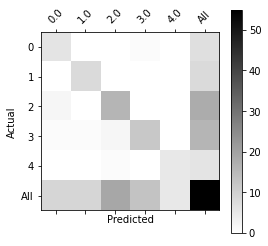

In [22]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(55,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

- Even with a mere 127 training examples, we can get a reasonably good model for Emojifying. 
    - This is due to the generalization power word vectors gives us. 
- Emojify-V1 will perform poorly on sentences such as *"This movie is not good and not enjoyable"* 
    - It doesn't understand combinations of words.
    - It just averages all the words' embedding vectors together, without considering the ordering of words. 

## Emojifier-V2: Using LSTMs in Keras

We're going to build an LSTM model that takes word **sequences** as input! This model will be able to account for word ordering. 

Emojifier-V2 will continue to use pre-trained word embeddings to represent words. We'll feed word embeddings into an LSTM, and the LSTM will learn to predict the most appropriate emoji. 

In [17]:
import numpy as np
import tensorflow
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)

**Model Overview:**

Here is the Emojifier-v2 we will implement:

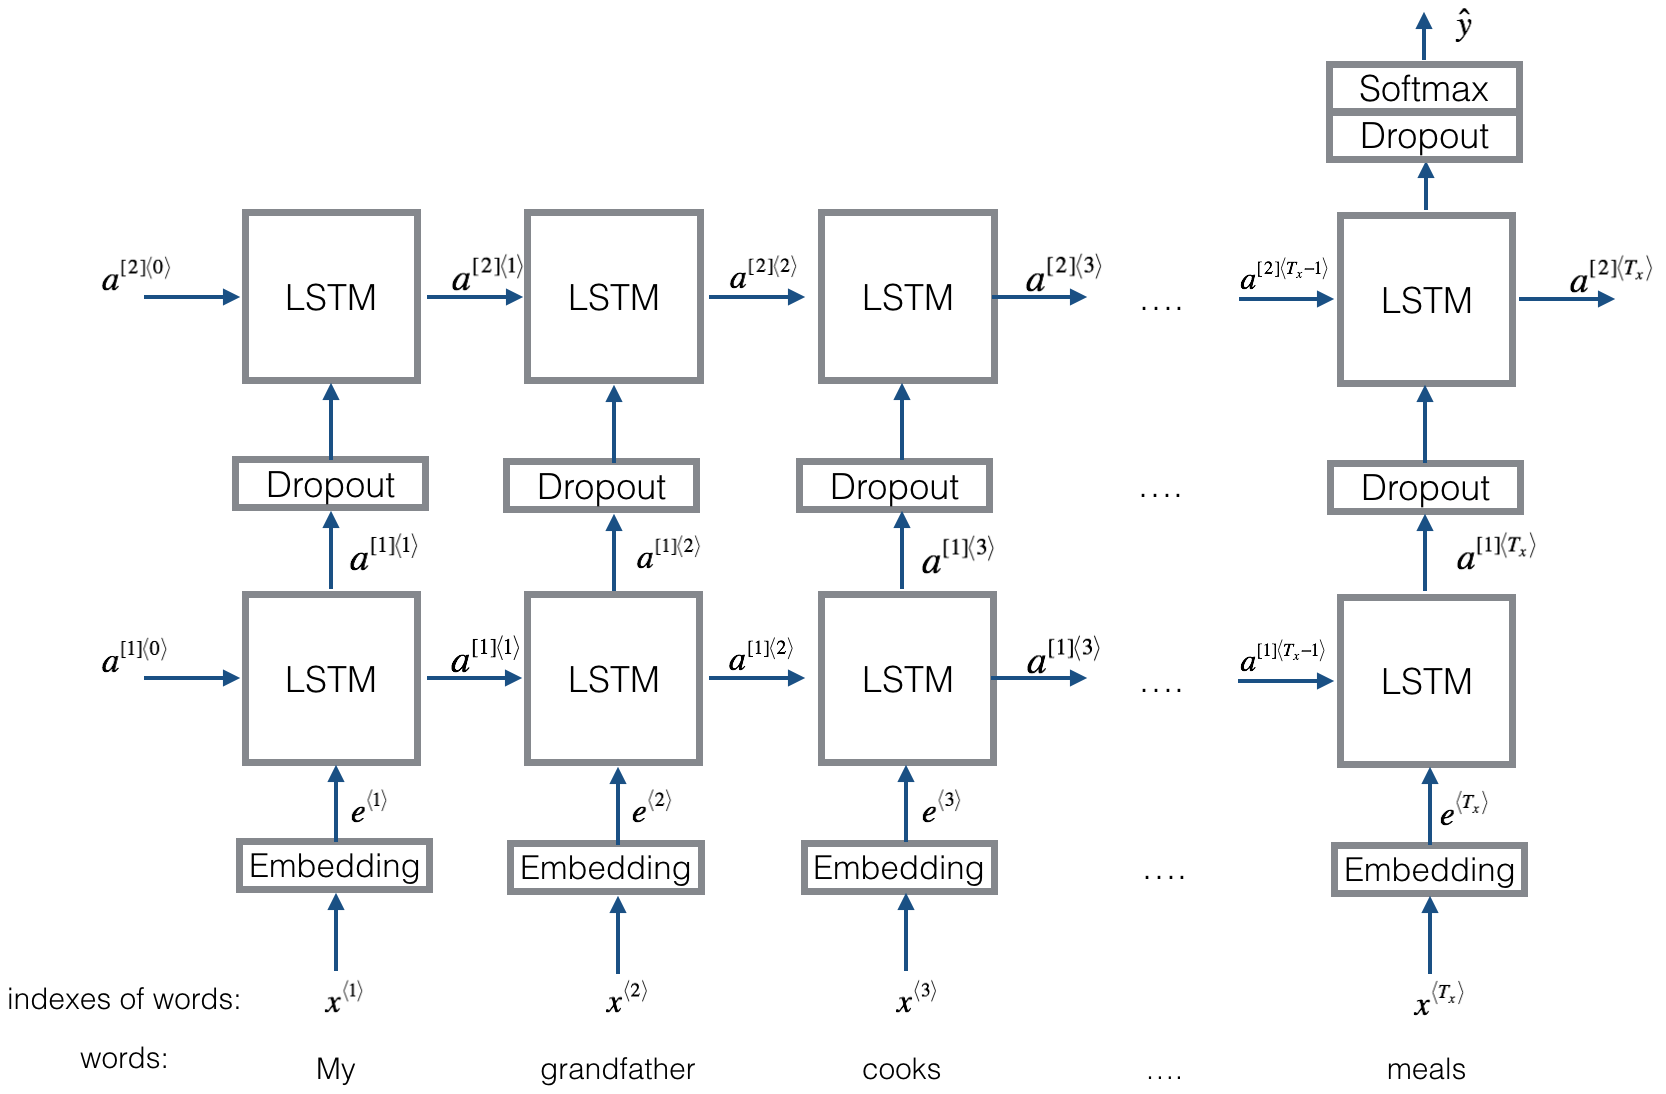

Keras and Mini-batching:

In this exercise, you want to train Keras using mini-batches. However, most deep learning frameworks require that all sequences in the same mini-batch have the **same length**. 

This is what allows vectorization to work: If you had a 3-word sentence and a 4-word sentence, then the computations needed for them are different (one takes 3 steps of an LSTM, one takes 4 steps) so it's just not possible to do them both at the same time.
    
Padding Handles Sequences of Varying Length:

* The common solution to handling sequences of **different length** is to use padding.  Specifically:
    * Set a maximum sequence length
    * Pad all sequences to have the same length. 
    
Example of Padding:

* Given a maximum sequence length of 20, we could pad every sentence with "0"s so that each input sentence is of length 20. 
* Thus, the sentence "I love you" would be represented as $(e_{I}, e_{love}, e_{you}, \vec{0}, \vec{0}, \ldots, \vec{0})$. 
* In this example, any sentences longer than 20 words would have to be truncated. 
* One way to choose the maximum sequence length is to just pick the length of the longest sentence in the training set. 

**The Embedding Layer:**

In Keras, the embedding matrix is represented as a "layer."

* The embedding matrix maps word indices to embedding vectors.
    * The word indices are positive integers.
    * The embedding vectors are dense vectors of fixed size.
    * A "dense" vector is the opposite of a sparse vector. It means that most of its values are non-zero.  As a counter-example, a one-hot encoded vector is not "dense."
* The embedding matrix can be derived in two ways:
    * Training a model to derive the embeddings from scratch. 
    * Using a pretrained embedding.
    
Using and Updating Pre-trained Embeddings:

In this section, we'll create an [Embedding()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer in Keras

* We will initialize the Embedding layer with GloVe 50-dimensional vectors. 
* In the code below, we'll observe how Keras allows you to either train or leave this layer fixed.  
    * Because our training set is quite small, we'll leave the GloVe embeddings fixed instead of updating them.

Inputs and Outputs to the Embedding Layer:

* The `Embedding()` layer's input is an integer matrix of size **(batch size, max input length)**. 
    * This input corresponds to sentences converted into lists of indices (integers).
    * The largest integer (the highest word index) in the input should be no larger than the vocabulary size.
* The embedding layer outputs an array of shape (batch size, max input length, dimension of word vectors).

* The figure shows the propagation of two example sentences through the embedding layer. 
    * Both examples have been zero-padded to a length of `max_len=5`.
    * The word embeddings are 50 units in length.
    * The final dimension of the representation is  `(2,max_len,50)`.     


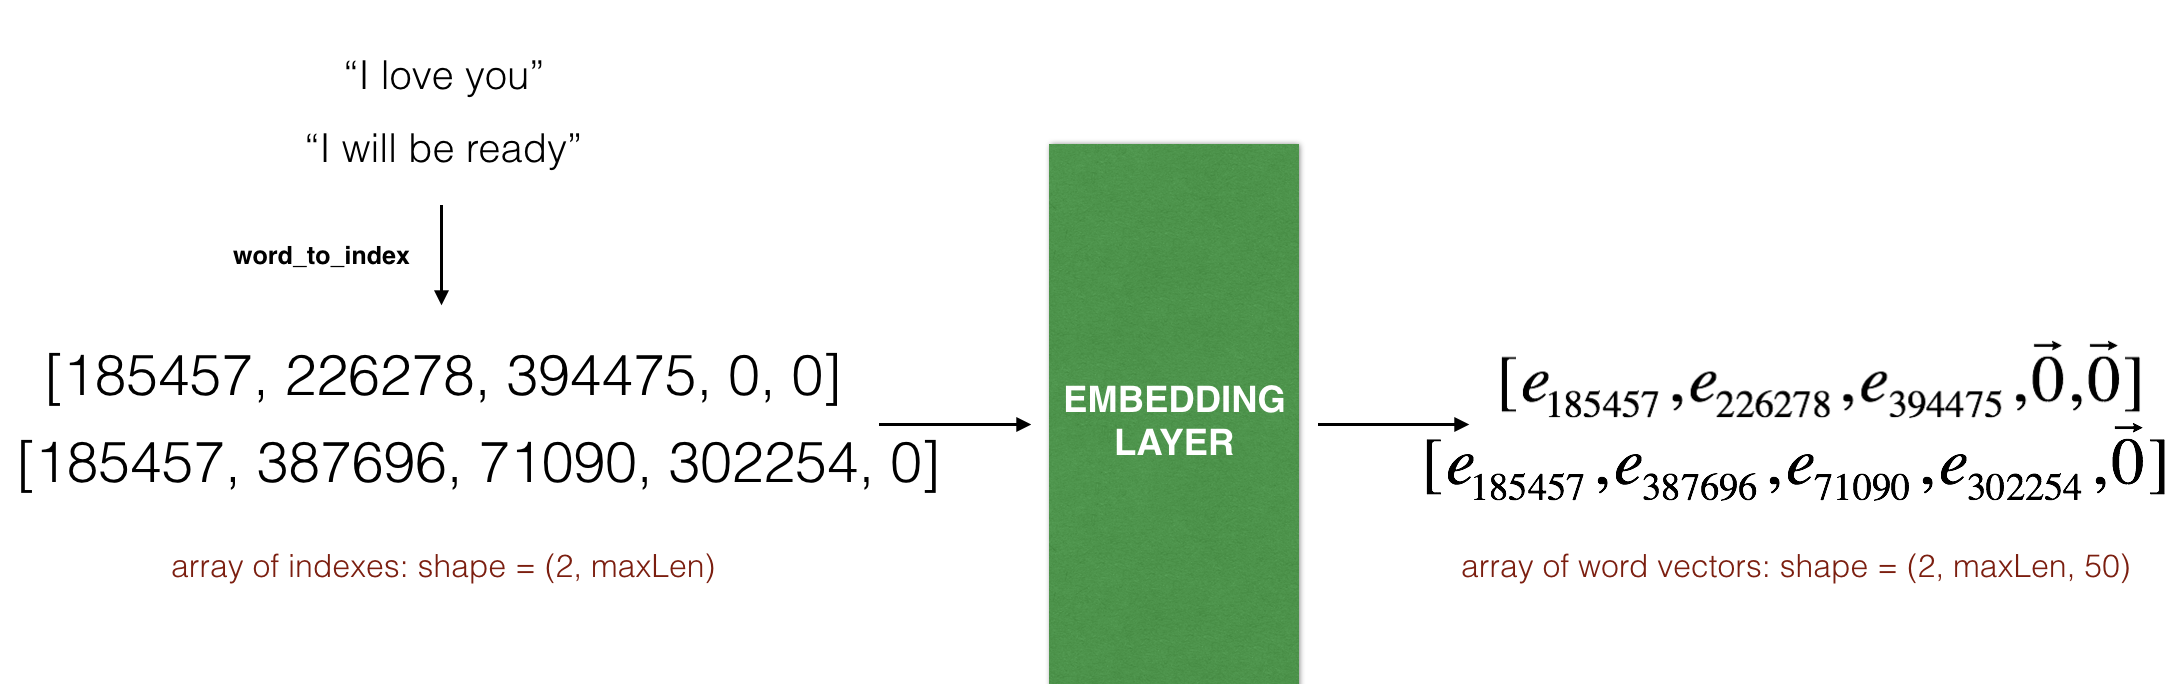

In [18]:
for idx, val in enumerate(["I", "like", "learning"]):
    print(idx, val)

0 I
1 like
2 learning


In [19]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """    
    m = X.shape[0]                                   #Number of training examples
    
    #Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros([m,max_len])
    
    for i in range(m):                               #Loop over training examples
        
        #Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        
        #Initialize j to 0
        j = 0
        
        #Loop over the words of sentence_words
        for w in sentence_words:
            #If w exists in the word_to_index dictionary
            if w in word_to_index:
                #Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                #Increment j to j + 1
                j =  j+1
                
    return X_indices

In [20]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


Now we'll build the `Embedding()` layer in Keras, using pre-trained word vectors. 

* The embedding layer takes as input a list of word indices.
    * `sentences_to_indices()` creates these word indices.
* The embedding layer will return the word embeddings for a sentence. 

In [21]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """   
    vocab_size = len(word_to_index) + 1              #Adding 1 to fit Keras embedding (requirement)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]     #Define dimensionality of your GloVe word vectors (=50)
      
    #Step 1
    #Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros([vocab_size,emb_dim])
    
    #Step 2
    #Set each row "idx" of the embedding matrix to be 
    #The word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    #Step 3
    #Define Keras embedding layer with the correct input and output sizes
    #Make it non-trainable.
    embedding_layer = Embedding(vocab_size, emb_dim ,trainable = False)

    #Step 4
    #Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    #Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [22]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim",embedding_layer.output_dim)

weights[0][1][1] = 0.39031
Input_dim 400001
Output_dim 50


In [34]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """    
    #Define sentence_indices as the input of the graph.
    #It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(shape=input_shape,dtype='int32')
    #Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)   
    #Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)
    #Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    #The returned output should be a batch of sequences, So, set return_sequences = True
    #If return_sequences = False, the LSTM returns only tht last output in output sequence
    X = LSTM(units=128,return_sequences = True)(embeddings)
    #Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    #Propagate X trough another LSTM layer with 128-dimensional hidden state
    #The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=256,return_sequences = False)(X)
    #Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    #Propagate X through a Dense layer with 5 units
    X = Dense(5)(X)
    #Add a softmax activation
    X = Activation('softmax')(X)
    
    #Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices,outputs=X)
        
    return model

* Because all sentences in the dataset are less than 10 words, `max_len = 10` was chosen.  
* You should see that our architecture uses 20,223,927 parameters, of which 20,000,050 (the word embeddings) are non-trainable, with the remaining 223,877 being trainable. 
* Because our vocabulary size has 400,001 words (with valid indices from 0 to 400,000) there are 400,001\*50 = 20,000,050 non-trainable parameters. 

In [35]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 10, 50)            20000050  
                                                                 
 lstm_2 (LSTM)               (None, 10, 128)           91648     
                                                                 
 dropout_2 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               394240    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285

In [36]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train the Model:

It's time to train our model! Our Emojifier-V2 `model` takes as input an array of shape (`m`, `max_len`) and outputs probability vectors of shape (`m`, `number of classes`). Thus, we have to convert X_train (array of sentences as strings) to X_train_indices (array of sentences as list of word indices), and Y_train (labels as indices) to Y_train_oh (labels as one-hot vectors).

In [37]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

In [38]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
5/5 [==============================] - 3s 7ms/step - loss: 1.5856 - accuracy: 0.2977
Epoch 2/50
5/5 [==============================] - 0s 6ms/step - loss: 1.4994 - accuracy: 0.3130
Epoch 3/50
5/5 [==============================] - 0s 6ms/step - loss: 1.3958 - accuracy: 0.4962
Epoch 4/50
5/5 [==============================] - 0s 6ms/step - loss: 1.2735 - accuracy: 0.5344
Epoch 5/50
5/5 [==============================] - 0s 6ms/step - loss: 1.0937 - accuracy: 0.6412
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 0.9277 - accuracy: 0.6641
Epoch 7/50
5/5 [==============================] - 0s 6ms/step - loss: 0.8043 - accuracy: 0.7405
Epoch 8/50
5/5 [==============================] - 0s 6ms/step - loss: 0.8013 - accuracy: 0.7557
Epoch 9/50
5/5 [==============================] - 0s 6ms/step - loss: 0.7103 - accuracy: 0.7634
Epoch 10/50
5/5 [==============================] - 0s 7ms/step - loss: 0.5810 - accuracy: 0.8015
Epoch 11/50
5/5 [======================

In [39]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print('Test accuracy = ', acc)

2/2 [==============================] - 1s 8ms/step - loss: 0.2177 - accuracy: 0.9455

Test accuracy =  0.9454545378684998


Let's see the mislabelled examples:

In [40]:
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😞 prediction: go away	⚾


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The parameter 'use_aliases' in emoji.emojize() is deprecated and will be removed in version 2.0.0. Use language='alias' instead.
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  # This is added back by InteractiveShellApp.init_path()


Now we can try it on our own example:

In [41]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['I cannot play'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

I cannot play ⚾


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The parameter 'use_aliases' in emoji.emojize() is deprecated and will be removed in version 2.0.0. Use language='alias' instead.
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  # This is added back by InteractiveShellApp.init_path()


LSTM Version Accounts for Word Order:

* The Emojify-V1 model did not "not feeling happy" correctly, but our implementation of Emojify-V2 got it right! 
    * If it didn't, be aware that Keras' outputs are slightly random each time, so this is probably why. 
* The current model still isn't very robust at understanding negation (such as "not happy")
    * This is because the training set is small and doesn't have a lot of examples of negation. 
    * If the training set were larger, the LSTM model would be much better than the Emojify-V1 model at understanding more complex sentences. 